# Modules

In [20]:
import gurobipy
from gurobipy import *

from random import randint
import pandas as pd
import numpy as np
import json

# for creating a responsive plot
%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Input Data

In [21]:
# Opening JSON file
instance_name = "./instances/toy_instance_horizon"
f = open(instance_name+".json")
# returns JSON object as a dictionary
data = json.load(f)

In [22]:
## Problem's parameters :

S = len(data["staff"]) # Number of individuals
H = data["horizon"] # Horizon
J = len(data["jobs"]) # Number of projects
Q = len(data["qualifications"]) # Number of qualifications

# Transform Data

In [23]:
## def functions from json
def vacations(collaborator, day):
    if day in collaborator["vacations"]:
        return 1
    else:
        return 0
def has_qualification(collaborator,qualification):
    # numbered collaborator
    if data["qualifications"][qualification] in data["staff"][collaborator]["qualifications"]:
        return 1
    else:
        return 0

def project_necessary_qualifications(project,qualification):
    if data["qualifications"][qualification] in data["jobs"][project]["working_days_per_qualification"].keys():
        return data["jobs"][project]["working_days_per_qualification"][data["qualifications"][qualification]]
    else:
        return 0
def gain(project):
    return project["gain"]

def date_rendu(project):
    return project["due_date"]

def penalite(project):
    return project["daily_penalty"]

# Model

In [24]:
# Create a new model
m = Model()

## Decision Variables

In [25]:
## variables
M = 1000
## Create variable rea (realisation of project)
X = {}
Y = {}
L={}
E= {}
Debut = {}
b = {}
shift_change={}

for i in range(S):
    for j in range(J):
        for k in range(Q):
            for t in range(H):
                X[i,j,k,t] = m.addVar(vtype=GRB.BINARY,name="X["+str(i)+","+str(j)+","+str(k)+","+str(t)+"]")
for j in range(J):
    Y[j]=m.addVar(vtype=GRB.BINARY,name="Y["+str(j)+"]")
    L[j]=m.addVar(vtype=GRB.INTEGER,name="L["+str(j)+"]")
    E[j]=m.addVar(vtype=GRB.INTEGER,name="E["+str(j)+"]")
    Debut[j]=m.addVar(vtype=GRB.INTEGER,name="Debut["+str(j)+"]")
for i in range(S):
    for j in range(J):
        for k in range(Q):
            for t in range(H):
                b[i,j,k,t] = m.addVar(vtype=GRB.BINARY,name="binary decision 2["+str(i)+","+str(j)+","+str(k)+","+str(t)+"]")
                shift_change[i,j,k,t] = m.addVar(vtype=GRB.BINARY,name="Shift Change ["+str(i)+","+str(j)+","+str(k)+","+str(t)+"]")

## Constraints

In [26]:
for i in range(S):
    for t in range(H):
        m.addConstr(quicksum(X[i,j,k,t] for j in range(J) for k in range(Q)) <=1)
for i in range(S):
    for t in range(H):
        if vacations(data["staff"][i],t)>0:
            m.addConstr(quicksum(X[i,j,k,t] for j in range(J) for k in range(Q))==0)
for i in range(S):
    for j in range(J):
        for k in range(Q):
            if (has_qualification(i,k)==0) or (project_necessary_qualifications(j,k)==0):
                for t in range(H):
                    m.addConstr(X[i,j,k,t]==0)
for j in range(J):
    for k in range(Q):
        if project_necessary_qualifications(j,k)>0:
            m.addConstr(Y[j]*project_necessary_qualifications(j,k) <= quicksum(X[i,j,k,t] for i in range(S) for t in range(H)))

for j in range(J):
    for k in range(Q):
        if project_necessary_qualifications(j,k)>0:
            m.addConstr(quicksum(X[i,j,k,t] for i in range(S) for t in range(H)) <= project_necessary_qualifications(j,k))
        
for i in range(S):
    for j in range(J):
        for k in range(Q):
            for t in range(H):
                m.addConstr(X[i,j,k,t]*t <= E[j])
for j in range(J):
    m.addConstr(E[j]-date_rendu(data["jobs"][j])<=L[j])
    m.addConstr(H-t*X[i,j,k,t] <= Debut[j])

## Objective function

In [27]:
## Set objective function

## Fonction obj 1: Maximize profits
profits = LinExpr()
profits = quicksum( Y[j]*gain(data["jobs"][j]) - L[j]*penalite(data["jobs"][j]) for j in range(J))

m.setObjective(profits,GRB.MAXIMIZE)

#Update Modèle
m.update()

In [28]:
m.params.outputflag = 0

solution_dict = {}
for nbr_shifts in range(H,0,-1):
    for nbr_jours_max_projet in range(H,0,-1):
        cons = []
        for i in range(S):
            for j in range(J):
                for k in range(Q):
                    for t in range(H-1):                                
                        cons.append(m.addConstr(shift_change[i,j,k,t]>=0))
                        cons.append(m.addConstr(shift_change[i,j,k,t]>=X[i,j,k,t+1]-X[i,j,k,t]))
                        cons.append(m.addConstr(shift_change[i,j,k,t]<=M*(1-b[i,j,k,t])))
                        #cons.append(m.addConstr(shift_change[i,j,k,t]<=X[i,j,k,t+1]-X[i,j,k,t]+M*b[i,j,k,t]))
                        #m.optimize()
            cons.append(m.addConstr(quicksum(shift_change[i,j,k,t] for j in range(J) for k in range(Q) for t in range(H)) <= nbr_shifts*2))
        cons.append(m.addConstr(E[j]-Debut[j] >= nbr_jours_max_projet))
        m.optimize()
        solution_dict[nbr_shifts,nbr_jours_max_projet] = json.loads(m.getJSONSolution())

        for c in cons:
            m.remove(c)

In [29]:
solution_reduite = {}
for key in solution_dict:
    solution_reduite[key[0],key[1],solution_dict[key]["SolutionInfo"]["ObjVal"]] = solution_dict[key]["Vars"]

# Solutions visualisation

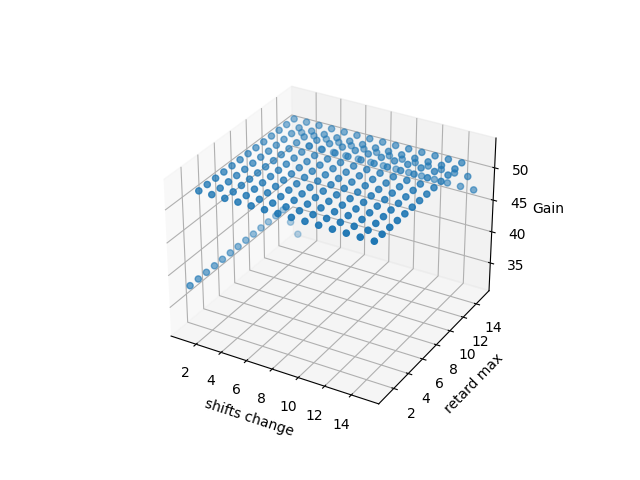

In [30]:
# Plotting the solutions with regards to the objective functions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x =[key[0] for key in solution_reduite]
y =[key[1] for key in solution_reduite]
z =[key[2] for key in solution_reduite]
ax.scatter(x, y, z)
ax.set_xlabel('shifts change')
ax.set_ylabel('retard max')
ax.set_zlabel('Gain')
plt.show()

## Non dominated Solutions

In [31]:
# select only non dominated solutions
def get_non_dominated_solutions(solution_reduite):
    # get the objective values
    obj_val = list(solution_reduite.keys())
    # get the number of solutions
    nb_sol = len(solution_reduite)
    # get the number of objectives
    nb_obj = 3
    # get the index of the solutions that are non dominated
    non_dominated_solutions = {}
    for i in range(nb_sol):
        dominated = False
        for j in range(nb_sol):
            if i != j:
                if all(obj_val[i][k] >= obj_val[j][k] for k in range(nb_obj-1)) and obj_val[i][nb_obj-1] <= obj_val[j][nb_obj-1]:
                    dominated = True
        if not dominated:
            non_dominated_solutions[obj_val[i]] = solution_reduite[obj_val[i]]
    return non_dominated_solutions

non_dominated_sol = get_non_dominated_solutions(solution_reduite)

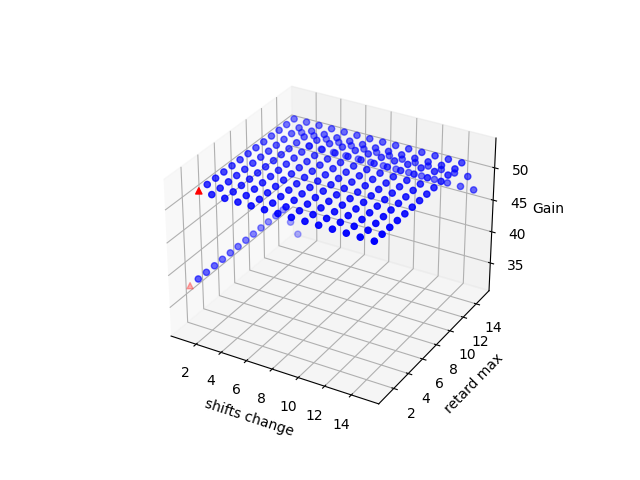

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dominated_sol = [key for key in solution_reduite if key not in non_dominated_sol]
x =[key[0] for key in dominated_sol]
y =[key[1] for key in dominated_sol]
z =[key[2] for key in dominated_sol]

x2 =[key[0] for key in non_dominated_sol]
y2 =[key[1] for key in non_dominated_sol]
z2 =[key[2] for key in non_dominated_sol]

ax.scatter(x, y, z, c='b', marker='o')
ax.scatter(x2, y2, z2, c='r', marker='^')
ax.set_xlabel('shifts change')
ax.set_ylabel('retard max')
ax.set_zlabel('Gain')
plt.show()

## Planning of a Solution

In [34]:
# Planning
def get_planning():
    # Dataframe with affectations
    planning = pd.DataFrame(np.nan, columns = ["day_"+str(i) for i in range(H)],index = [i for i in range(S)])
    for i in range(S): # I
        for j in range(J): # P
            for k in range(Q): # Q
                for t in range(H): # J
                    if X[i,j,k,t].x > 0:
                        planning.iloc[i,j] = k
    ## colors cells with regard to project
    color_pro = {}
    for i in range(J):
        color_pro[i] = '#%06X' % randint(0, 0xFFFFFF)

    df_color = pd.DataFrame(np.nan, columns = ["day_"+str(i) for i in range(H)],index = [i for i in range(S)])
    for i in range(S): 
        for j in range(J): 
            for k in range(Q):
                for t in range(H): 
                    if X[i,j,k,t].x > 0:
                            df_color.iloc[i,j] = color_pro[k]
    df_color = df_color.applymap(lambda x: 'background-color: {}'.format(x))
    def highlight_1(x):
        return pd.DataFrame(df_color.values, columns=x.columns)
    planning = planning.astype('Int64')
    planning = planning.style.apply(highlight_1,axis=None)
    # Mapping colors to projects
    proj_col = pd.DataFrame()
    i=0
    for project in range(5):
        proj_col = pd.concat([proj_col,pd.DataFrame({'project':project,'color': 'background-color: ' + color_pro[i]},index=[i])], axis=0)
        i+=1
    def highlight_2(x):
        return x
    proj_col = proj_col.style.apply(highlight_2,axis=None, subset=['color'])
    return planning, proj_col

planning, proj_col = get_planning()

In [35]:
planning

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14
0,0,,,2,,,,,,,,,,,
1,1,,0,1,,,,,,,,,,,
2,2,,2,,2,,,,,,,,,,


In [36]:
proj_col

,project,color
0,0,background-color: #A095BF
1,1,background-color: #9B8DAA
2,2,background-color: #632857
3,3,background-color: #07EDCD
4,4,background-color: #F0B46D


# systèmes de choix/préférence

In [37]:
dico = {}
for count,value in enumerate(solution_reduite):
    dico[count]=value

In [38]:
def bordas_ranking(dico):
    df = pd.DataFrame.from_dict(dico, orient='index', columns=['gain','shift_change','diff'])
    df['default_rank'] = df['gain'].rank(method='min', ascending=False)
    df['shift_change_rank'] = df['shift_change'].rank(method='min', ascending=False)
    df['diff_rank'] = df['diff'].rank(method='min', ascending=False)
    df['borda'] = df['default_rank'] + df['shift_change_rank'] + df['diff_rank']

    df = df.sort_values(by = 'borda', ascending = True)
    return df


def somme_ponderee(dico,poids1=1,poids2=0.5,poids3=0.5):
    for i in dico.keys():
        dico[i] = dico[i],np.sum(dico[i]*np.array([poids1,poids2,poids3]))
    return {k: v[0] for k, v in sorted(dico.items(), key=lambda item: item[0])}

def fonction_seuil(dico,seuil,fonction_a_appeler):
    max_gain = max(np.array(list(dico.values())).T[0])
    list_to_keep = {}
    for key, values in enumerate(dico.values()):
        if values[0] >=max_gain*seuil:
            list_to_keep[key] = dico[key]
    print(list_to_keep)
    return fonction_a_appeler(list_to_keep)

In [40]:
fonction_seuil(dico,0.99,bordas_ranking)

{0: (15, 15, 47), 1: (15, 14, 50), 2: (15, 13, 53), 3: (15, 12, 53), 4: (15, 11, 53), 5: (15, 10, 53), 6: (15, 9, 53), 7: (15, 8, 53), 8: (15, 7, 53), 9: (15, 6, 53), 10: (15, 5, 53), 11: (15, 4, 53), 12: (15, 3, 53), 13: (15, 2, 53), 14: (15, 1, 53)}


,gain,shift_change,diff,default_rank,shift_change_rank,diff_rank,borda
2,15,13,53,1.0,3.0,1.0,5.0
3,15,12,53,1.0,4.0,1.0,6.0
4,15,11,53,1.0,5.0,1.0,7.0
5,15,10,53,1.0,6.0,1.0,8.0
6,15,9,53,1.0,7.0,1.0,9.0
7,15,8,53,1.0,8.0,1.0,10.0
8,15,7,53,1.0,9.0,1.0,11.0
9,15,6,53,1.0,10.0,1.0,12.0
10,15,5,53,1.0,11.0,1.0,13.0
11,15,4,53,1.0,12.0,1.0,14.0


## Apprentissage des préférences à partir d'info à priori